In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.phy
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Using GPU 0



E0000 00:00:1744148787.781742  314183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744148787.789073  314183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744148787.810007  314183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744148787.810032  314183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744148787.810033  314183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744148787.810035  314183 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Additional external libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Sionna components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, \
    RadioMapSolver, PathSolver, subcarrier_frequencies, Camera
from sionna.phy import config
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, RZFPrecodedChannel, LMMSEPostEqualizationSINR
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.nr.utils import decode_mcs_index
from sionna.phy.utils import log2, dbm_to_watt, lin_to_db, watt_to_dbm
from sionna.sys import PHYAbstraction, OuterLoopLinkAdaptation, \
    PFSchedulerSUMIMO, downlink_fair_power_control, InnerLoopLinkAdaptation
from sionna.sys.utils import spread_across_subcarriers

# Internal computational precision
config.precision = 'single'  # 'single' or 'double'

# Set random seed for reproducibility
config.seed = 48

# Toggle to False to use the preview widget
# instead of rendering for scene visualization
no_preview = True

I0000 00:00:1744148791.318628  314183 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# Number of simulated slots
num_slots = 200

# Time/frequency resource grid
carrier_frequency = 3.5e9
num_subcarriers = 128
subcarrier_spacing = 30e3
num_ofdm_symbols = 12

# Start/end 3D position of the users
# You can try and change these values to see how the system behaves
ut_pos_start = np.array([[-25,   0, 1.5],  # user 1
                         [24,  55, 1.5],  # user 2
                         [88,   0, 1.5]])  # user 3

ut_pos_end = np.array([[-25,  30, 1.5],    # user 1
                       [24,  15, 1.5],    # user 2
                       [65,    0, 1.5]])   # user 3

# Base station position and look-at direction
bs_pos = np.array([32.5, 10.5, 23])
bs_look_at = np.array([22, -8, 0])

# Number of users and base stations
num_bs = 1
num_ut = ut_pos_start.shape[0]

# Environment temperature
temperature = 294  # [K]

# BLER target value
bler_target = .1  # in [0; 1]

# MCS table index
mcs_table_index = 1

# Base station transmit power
# Low power is sufficient here thanks to lack of interference
bs_power_dbm = 10  # [dBm]
bs_power_watt = dbm_to_watt(bs_power_dbm)  # [W]

# Number of antennas at the transmitter and receiver
num_bs_ant = num_ut
num_ut_ant = 1

In [4]:
# Number of streams per user and base station
num_streams_per_ut = num_ut_ant
num_streams_per_bs = num_ut_ant * num_ut

# Noise power per subcarrier
no = BOLTZMANN_CONSTANT * temperature * subcarrier_spacing

# Stream management: Rx to Tx association
# Since there is only a single BS, all UTs are connected to it
rx_tx_association = np.ones([num_ut, num_bs])
stream_management = StreamManagement(rx_tx_association, num_streams_per_bs)

# OFDM resource grid
resource_grid = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                             fft_size=num_subcarriers,
                             subcarrier_spacing=subcarrier_spacing,
                             num_tx=num_ut,
                             num_streams_per_tx=num_streams_per_ut)

# Subcarrier frequencies
frequencies = subcarrier_frequencies(num_subcarriers=num_subcarriers,
                                     subcarrier_spacing=subcarrier_spacing)

In [5]:
# Configure Sionna RT
p_solver = PathSolver()

# Load the scene
scene = load_scene(sionna.rt.scene.simple_street_canyon)

# Set the scene parameters
scene.frequency = carrier_frequency
scene.bandwidth = num_subcarriers*subcarrier_spacing
scene.tx_array = PlanarArray(
    num_rows=num_bs_ant, num_cols=1, pattern="tr38901", polarization='V')
scene.rx_array = PlanarArray(
    num_rows=1, num_cols=num_ut_ant, pattern="dipole", polarization='V')

# Add base station to the scene
scene.add(Transmitter(f"bs0", position=bs_pos, look_at=bs_look_at,
                      power_dbm=bs_power_dbm, display_radius=3))
for ut in range(num_ut):
    scene.add(Receiver(f"ut{ut}", position=ut_pos_start[ut],
                    display_radius=1, color=[0, 0, 0]))

In [6]:
# Path solver: Compute propagation paths between the antennas of all
# transmitters and receivers in the scene using ray tracing
paths = p_solver(scene, max_depth=8, refraction=False)

# Transform to channel frequency response (CFR)
# [num_ut, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, num_subcarriers]
h_freq = paths.cfr(frequencies=frequencies,
                   sampling_frequency=1/resource_grid.ofdm_symbol_duration,
                   num_time_steps=resource_grid.num_ofdm_symbols,
                   out_type="tf")
h_freq.shape

TensorShape([3, 1, 1, 3, 12, 128])

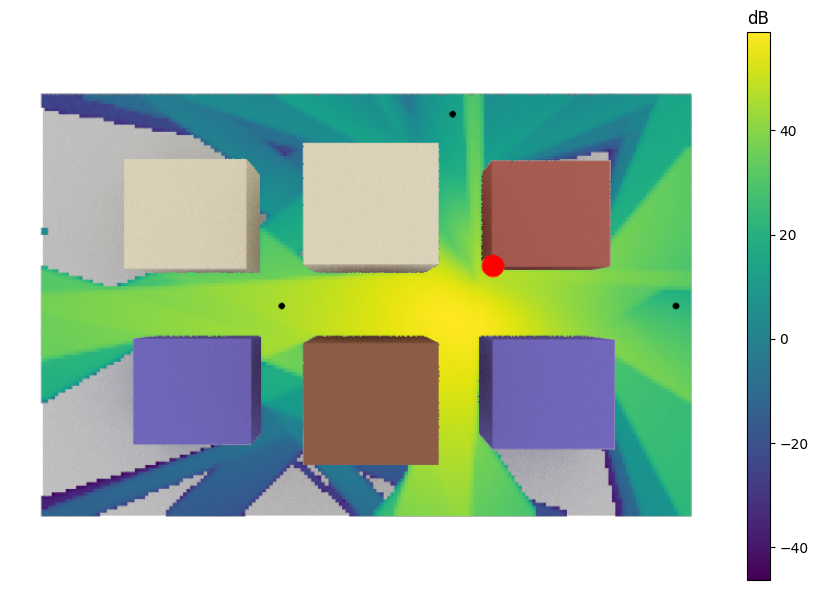

In [7]:
# Compute the Radio Map for the scene and visualize it
rm_solver = RadioMapSolver()
rm = rm_solver(scene, max_depth=8, refraction=False,
               cell_size=(1, 1), samples_per_tx=10000000)

if no_preview:
    cam = Camera(position=[-0, 0, 250],
                 orientation=np.array([0, np.pi/2, -np.pi/2]))
    scene.render(camera=cam,
                 radio_map=rm,
                 rm_metric="sinr",
                 rm_show_color_bar=True)
else:
    scene.preview(radio_map=rm, rm_metric="sinr")

In [8]:
# Initialize the PHYAbstraction class
phy_abs = PHYAbstraction()

# Instantiate an OLLA object
olla = OuterLoopLinkAdaptation(phy_abs,
                               num_ut=num_ut,
                               bler_target=bler_target,
                               batch_size=[num_bs])

# Instantiate a Scheduler
scheduler = PFSchedulerSUMIMO(
    num_ut,
    num_subcarriers,
    num_ofdm_symbols,
    batch_size=[num_bs],
    num_streams_per_ut=num_streams_per_ut,
    beta=.9)

In [ ]:
# Transmit power is spread uniformly across subcarriers and streams
tx_power = np.ones(
    shape=[1, num_bs, num_streams_per_bs, num_ofdm_symbols, num_subcarriers])
tx_power *= bs_power_watt / num_streams_per_bs / num_subcarriers

precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management)
h_eff = precoded_channel(h_freq[tf.newaxis, ...], tx_power=tx_power, alpha=no)
# LMMSE post-equalization SINR computation
lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                stream_management=stream_management)
# [batch_size, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
sinr = lmmse_posteq_sinr(h_eff, no=no, interference_whitening=True)

I0000 00:00:1744148799.602951  314183 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x5cea4ed6ee80


In [13]:
sinr.shape

TensorShape([1, 12, 128, 3, 1])

In [12]:
h_eff.shape

TensorShape([1, 3, 1, 1, 3, 12, 128])

In [14]:
illa = InnerLoopLinkAdaptation(phy_abs, bler_target)

mcs_index = illa(sinr=sinr,
                 mcs_table_index=mcs_table_index)

In [15]:
print("MCS indices: ",mcs_index.numpy())

MCS indices:  [[27 20 25]]


In [16]:
direction = 'downlink'  # 'downlink' or 'uplink'
mcs_category = int(direction == 'downlink')
num_decoded_bits, harq_feedback, sinr_eff, bler, tbler = \
    phy_abs(mcs_index,
            sinr=sinr,
            mcs_table_index=mcs_table_index,
            mcs_category=mcs_category)

sinr_eff = sinr_eff.numpy()

In [17]:
sinr_eff

array([[1000.      ,   17.595705,   64.22413 ]], dtype=float32)

In [19]:
lin_to_db(sinr_eff)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[30.      , 12.454066, 18.07698 ]], dtype=float32)>